<a href="https://colab.research.google.com/github/tripidhoble/Hackathon-Project/blob/master/Marketing_Campaign.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [859]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Import Libraries**

In [0]:
# Import Libraries
import numpy as np
import pandas as pd

#Common Model Algorithms
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble,\
                          discriminant_analysis, gaussian_process
from xgboost import XGBClassifier

#Common Model Helpers
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score,\
                            recall_score, f1_score, roc_auc_score, classification_report,\
                            roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import ClusterCentroids, TomekLinks
from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_selection import SelectKBest, f_classif , chi2
from sklearn.linear_model import LogisticRegression

#Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

#Configure Visualization Defaults
#%matplotlib inline = show plots in Jupyter Notebook browser
%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')

import warnings
warnings.filterwarnings("ignore")

**Common Functions**

In [0]:
def dispaly_missing_values(dataset):
  Missing_Data = pd.DataFrame()
  Missing_Data['count'] = dataset.isnull().sum()
  Missing_Data['% count'] = (dataset.isnull().sum()/len(dataset))*100
  print(Missing_Data)

In [0]:

def feature_selection1(df,num_col,cat_col,y):
    df1=df[num_col]
    skb1= SelectKBest(score_func=f_classif, k=3)
    predictors1=skb1.fit_transform(df1,df[y])
    scores1 = list(skb1.scores_)
    top_k_index1 = skb1.get_support(True)
    top_k_predictors1 =df1.columns[top_k_index1]
    
    df2=df[cat_col]
    skb2=SelectKBest(score_func=chi2,k=12)
    predictors2=skb2.fit_transform(df2,df[y])
    scores2 = list(skb2.scores_)
    top_k_index2 = skb2.get_support(True)
    top_k_predictors2 =df2.columns[top_k_index2]
    x=df[top_k_predictors1]
    y=df[top_k_predictors2]
    return(pd.concat([x, y], axis=1, sort=False))
  
def feature_selection(dataset,num_cols,cat_cols,target):
    
    skb1= SelectKBest(score_func=f_classif, k=3)
    skb1.fit_transform(dataset[num_cols],dataset[target])
    top_k_index1 = skb1.get_support(True)
    top_k_predictors1 = dataset.columns[top_k_index1]
    
    skb2 = SelectKBest(score_func=f_classif, k=12)
    skb2.fit_transform(dataset[cat_cols],dataset[target])
    top_k_index2 = skb1.get_support(True)
    top_k_predictors2 = dataset.columns[top_k_index2]
    
    x = dataset[top_k_predictors1]
    y = dataset[top_k_predictors2]
    df = pd.concat([x, y], axis=1, sort=False)
    
    return df

In [0]:

def plot_confusion_matrix(actual_target, pred_target):
  conf_mat = confusion_matrix(y_true=actual_target, y_pred=pred_target)
  print('Confusion matrix:\n', conf_mat)

  labels = ['Class 0', 'Class 1']
  fig = plt.figure()
  ax = fig.add_subplot(111)
  cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
  fig.colorbar(cax)
  ax.set_xticklabels([''] + labels)
  ax.set_yticklabels([''] + labels)
  plt.xlabel('Predicted')
  plt.ylabel('Expected')
  plt.show()

In [0]:
def dispaly_model_parameters(actual_target, pred_target):
        y_test = actual_target
        y_pred = pred_target
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        roc = roc_auc_score(y_test, y_pred)
        cr = classification_report(y_test, y_pred)
        
        print(pd.crosstab(y_test, y_pred))
        print("Accuracy:{}\n Precision: {}\n Recall: {}\n f1_score:{}\n roc_auc_score:{}\
               \n classification_report:\n {}".format(accuracy, precision, recall, f1, roc, cr))

In [0]:
def plot_roc_curve(actual_target, probs):
    fpr, tpr, threshold = roc_curve(actual_target, probs)
    roc_auc = auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [0]:
def fit_model(sel_clf_method, train_data, train_target, test_data):

  if(sel_clf_method == 'LogisticRegression_BalanceWeight'):
    lr = LogisticRegression(class_weight='balanced')
    lr.fit(train_data, train_target)
    pred_target = lr.predict(test_data)
    probs = lr.predict_proba(test_data)[:, 1]  
    
  elif(sel_clf_method == 'Decision_Tree'):
    dt = DecisionTreeClassifier(max_depth=3, random_state = 0)
    dt.fit(train_data, train_target)
    pred_target = dt.predict(test_data)
    probs = dt.predict_proba(test_data)[:, 1]  
    
  elif(sel_clf_method == 'RandomForest_BalancWeight'):
    rf= RandomForestClassifier(n_estimators=100, max_depth=3,class_weight='balanced',random_state=27)
    rf.fit(train_data,train_target)
    pred_target = rf.predict(test_data)
    probs = rf.predict_proba(test_data)[:, 1] 
    
  elif(sel_clf_method == 'RandomForest'):
    rf_clf = RandomForestClassifier(n_estimators = 100, n_jobs = 100, max_depth=3, min_samples_leaf = 100, random_state = 0)
    rf_clf.fit(train_data, train_target)
    pred_target = rf_clf.predict(test_data)
    probs = rf_clf.predict_proba(test_data)[:, 1] 
    
  elif(sel_clf_method == 'GridSearch_RandomForest'):
    parameter_grid = {"max_depth": [3, None],
                "max_features": [1, 3, 10],
                "min_samples_split": [2, 3, 10],
                "min_samples_leaf": [1, 3, 10],
                "bootstrap": [True, False],
                "criterion": ["gini", "entropy"]}

    clf = RandomForestClassifier(random_state = 0)
    grid_search = GridSearchCV(estimator = clf, param_grid = parameter_grid)
    grid_search.fit(train_data, train_target)
    pred_target = grid_search.predict(test_data)
    #score_gs = grid_search.score(X_test, y_test)
    probs = grid_search.predict_proba(test_data)[:, 1] 
  else:
    print("Invalid parameters!")
    
    
  return pred_target, probs

In [0]:
def resample_data(resample_model , train_data , test_data ):
  
  model_obj = resample_model(random_state = 0)
  
  X_sample, y_sample = model_obj.fit_sample(train_data, test_data)
  
  return X_sample, y_sample

In [0]:
def Resample_FitModel_Validate(resample_model, clf_method, plot,\
                               train_data, train_target, test_data, test_target):
  if(resample_model != None):
    train_data1 , train_target1 = resample_data(resample_model , train_data , train_target)
  else:
    train_data1 , train_target1 = train_data, train_target
    
  pred_target, probs = fit_model(clf_method, train_data1, train_target1, test_data)
  
  dispaly_model_parameters(test_target, pred_target)
  
  if(plot != False):
    plot_roc_curve(test_target, probs)

**Load Data**

In [0]:
campaign_data = pd.read_csv("drive/My Drive/data/bank-additional-full.csv")
campaign_data_validate = pd.read_csv("drive/My Drive/data/bank-additional.csv")

In [0]:
datasets = [campaign_data, campaign_data_validate]

**Analyse Data**

In [871]:
campaign_data.sample(5)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
38613,37,admin.,married,high.school,no,no,no,cellular,nov,mon,...,4,999,0,nonexistent,-3.4,92.649,-30.1,0.722,5017.5,no
1321,35,blue-collar,married,basic.9y,unknown,no,no,telephone,may,thu,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
33340,37,admin.,married,high.school,no,yes,no,cellular,may,tue,...,5,999,0,nonexistent,-1.8,92.893,-46.2,1.291,5099.1,no
40485,27,admin.,married,university.degree,no,no,no,cellular,aug,thu,...,3,6,1,success,-1.7,94.027,-38.3,0.899,4991.6,yes
41006,37,housemaid,married,university.degree,no,no,no,cellular,oct,thu,...,1,6,2,success,-1.1,94.601,-49.5,1.025,4963.6,yes


In [872]:
campaign_data_validate.sample(5)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
299,28,unemployed,single,university.degree,no,yes,no,cellular,may,mon,...,1,999,0,nonexistent,-1.8,92.893,-46.2,1.244,5099.1,no
2475,41,technician,single,professional.course,no,yes,no,cellular,may,tue,...,2,999,1,failure,-1.8,92.893,-46.2,1.291,5099.1,no
2199,32,technician,single,university.degree,no,no,no,cellular,may,fri,...,1,999,0,nonexistent,-1.8,92.893,-46.2,1.250,5099.1,no
4010,54,management,divorced,university.degree,no,yes,yes,cellular,may,wed,...,2,999,1,failure,-1.8,92.893,-46.2,1.334,5099.1,no
2699,56,admin.,married,high.school,no,no,no,cellular,sep,thu,...,1,999,0,nonexistent,-3.4,92.379,-29.8,0.778,5017.5,no


In [873]:
print("campaign_data info: ")
campaign_data.info()

campaign_data info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
age               41188 non-null int64
job               41188 non-null object
marital           41188 non-null object
education         41188 non-null object
default           41188 non-null object
housing           41188 non-null object
loan              41188 non-null object
contact           41188 non-null object
month             41188 non-null object
day_of_week       41188 non-null object
duration          41188 non-null int64
campaign          41188 non-null int64
pdays             41188 non-null int64
previous          41188 non-null int64
poutcome          41188 non-null object
emp.var.rate      41188 non-null float64
cons.price.idx    41188 non-null float64
cons.conf.idx     41188 non-null float64
euribor3m         41188 non-null float64
nr.employed       41188 non-null float64
y                 41188 non-null object
dtypes: float64(5), int64(5), 

In [874]:
print("campaign_data_validate info: ")
campaign_data_validate.info()

campaign_data_validate info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4119 entries, 0 to 4118
Data columns (total 21 columns):
age               4119 non-null int64
job               4119 non-null object
marital           4119 non-null object
education         4119 non-null object
default           4119 non-null object
housing           4119 non-null object
loan              4119 non-null object
contact           4119 non-null object
month             4119 non-null object
day_of_week       4119 non-null object
duration          4119 non-null int64
campaign          4119 non-null int64
pdays             4119 non-null int64
previous          4119 non-null int64
poutcome          4119 non-null object
emp.var.rate      4119 non-null float64
cons.price.idx    4119 non-null float64
cons.conf.idx     4119 non-null float64
euribor3m         4119 non-null float64
nr.employed       4119 non-null float64
y                 4119 non-null object
dtypes: float64(5), int64(5), object(11)
mem

In [875]:
print("campaign_data description: ")
campaign_data.describe(include = 'all')

campaign_data description: 


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
count,41188.00000,41188,41188,41188,41188,41188,41188,41188,41188,41188,...,41188.000000,41188.000000,41188.000000,41188,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188
unique,NaN,12,4,8,3,3,3,2,10,5,...,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,2
top,NaN,admin.,married,university.degree,no,yes,no,cellular,may,thu,...,NaN,NaN,NaN,nonexistent,NaN,NaN,NaN,NaN,NaN,no
freq,NaN,10422,24928,12168,32588,21576,33950,26144,13769,8623,...,NaN,NaN,NaN,35563,NaN,NaN,NaN,NaN,NaN,36548
mean,40.02406,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.567593,962.475454,0.172963,NaN,0.081886,93.575664,-40.502600,3.621291,5167.035911,NaN
std,10.42125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.770014,186.910907,0.494901,NaN,1.570960,0.578840,4.628198,1.734447,72.251528,NaN
min,17.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.000000,0.000000,0.000000,NaN,-3.400000,92.201000,-50.800000,0.634000,4963.600000,NaN
25%,32.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.000000,999.000000,0.000000,NaN,-1.800000,93.075000,-42.700000,1.344000,5099.100000,NaN
50%,38.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.000000,999.000000,0.000000,NaN,1.100000,93.749000,-41.800000,4.857000,5191.000000,NaN
75%,47.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.000000,999.000000,0.000000,NaN,1.400000,93.994000,-36.400000,4.961000,5228.100000,NaN


In [876]:
print("campaign_data_validate description: ")
campaign_data_validate.describe(include = 'all')

campaign_data_validate description: 


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
count,4119.000000,4119,4119,4119,4119,4119,4119,4119,4119,4119,...,4119.000000,4119.000000,4119.000000,4119,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000,4119
unique,NaN,12,4,8,3,3,3,2,10,5,...,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,2
top,NaN,admin.,married,university.degree,no,yes,no,cellular,may,thu,...,NaN,NaN,NaN,nonexistent,NaN,NaN,NaN,NaN,NaN,no
freq,NaN,1012,2509,1264,3315,2175,3349,2652,1378,860,...,NaN,NaN,NaN,3523,NaN,NaN,NaN,NaN,NaN,3668
mean,40.113620,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.537266,960.422190,0.190337,NaN,0.084972,93.579704,-40.499102,3.621356,5166.481695,NaN
std,10.313362,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.568159,191.922786,0.541788,NaN,1.563114,0.579349,4.594578,1.733591,73.667904,NaN
min,18.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.000000,0.000000,0.000000,NaN,-3.400000,92.201000,-50.800000,0.635000,4963.600000,NaN
25%,32.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.000000,999.000000,0.000000,NaN,-1.800000,93.075000,-42.700000,1.334000,5099.100000,NaN
50%,38.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.000000,999.000000,0.000000,NaN,1.100000,93.749000,-41.800000,4.857000,5191.000000,NaN
75%,47.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.000000,999.000000,0.000000,NaN,1.400000,93.994000,-36.400000,4.961000,5228.100000,NaN


In [0]:
# replace unknown as np.NAN 
for dataset in datasets:
  for col in dataset.columns:
    dataset[col] = dataset[col].replace('unknown', np.NAN)

In [878]:
print("Missing values for 'campaign_data'")
dispaly_missing_values(campaign_data)
print("--"*20)
print("Missing values for 'campaign_data_validate'")
dispaly_missing_values(campaign_data_validate)

Missing values for 'campaign_data'
                count    % count
age                 0   0.000000
job               330   0.801204
marital            80   0.194231
education        1731   4.202680
default          8597  20.872584
housing           990   2.403613
loan              990   2.403613
contact             0   0.000000
month               0   0.000000
day_of_week         0   0.000000
duration            0   0.000000
campaign            0   0.000000
pdays               0   0.000000
previous            0   0.000000
poutcome            0   0.000000
emp.var.rate        0   0.000000
cons.price.idx      0   0.000000
cons.conf.idx       0   0.000000
euribor3m           0   0.000000
nr.employed         0   0.000000
y                   0   0.000000
----------------------------------------
Missing values for 'campaign_data_validate'
                count    % count
age                 0   0.000000
job                39   0.946832
marital            11   0.267055
education         167 

**Handling missing values**

In [879]:
def Fill_Missing_Values(datasets):
  ###COMPLETING: complete or delete missing values in train and test/validation dataset
  
  cols = ['job','marital','education','default','housing','loan']
  
  for dataset in datasets: 
    for col in cols:
      #complete job with mode
      dataset[col].fillna(dataset[col].dropna().mode()[0], inplace = True)
  return datasets

datasets = Fill_Missing_Values(datasets)

print("Missing values for 'campaign_data'")
dispaly_missing_values(campaign_data)
print("--"*20)
print("Missing values for 'campaign_data_validate'")
dispaly_missing_values(campaign_data_validate)

Missing values for 'campaign_data'
                count  % count
age                 0      0.0
job                 0      0.0
marital             0      0.0
education           0      0.0
default             0      0.0
housing             0      0.0
loan                0      0.0
contact             0      0.0
month               0      0.0
day_of_week         0      0.0
duration            0      0.0
campaign            0      0.0
pdays               0      0.0
previous            0      0.0
poutcome            0      0.0
emp.var.rate        0      0.0
cons.price.idx      0      0.0
cons.conf.idx       0      0.0
euribor3m           0      0.0
nr.employed         0      0.0
y                   0      0.0
----------------------------------------
Missing values for 'campaign_data_validate'
                count  % count
age                 0      0.0
job                 0      0.0
marital             0      0.0
education           0      0.0
default             0      0.0
housing     

**Creating Feature**

In [880]:

def Feature_Creation(datasets):
    
    salaried = ['blue-collar', 'services', 'admin.', 'entrepreneur',
                 'self-employed', 'technician', 'management']
    non_salaried = ['student', 'retired', 'housemaid.', 'unemployed','housemaid']

    high_education = ['high.school', 'university.degree',
                      'professional.course' ]
    low_education = ['basic.9y', 'basic.6y', 'basic.4y', 'illiterate']    
    
    #Binning age:
    cut_points_age = [31,51,71]
    labels_age_bin = ["low","medium","high","very high"]
    
    #Binning pdays:
    cut_points_pdays = [7,14,21,28]
    labels_weeks = [0,1,2,3,4]
    
    #Binning duration:
    cut_points_duration = [7,14,21,28]
    labels_weeks = [0,1,2,3,4]

    #Binning:
    def binning(col, cut_points, labels=None):
      #Define min and max values:
      minval = col.min()
      maxval = col.max()

      #create list by adding min and max to cut_points
      break_points = [minval] + cut_points + [maxval]

      #if no labels provided, use default labels 0 ... (n-1)
      if not labels:
        labels = range(len(cut_points)+1)

      #Binning using cut function of pandas
      colBin = pd.cut(col,bins=break_points,labels=labels,include_lowest=True)
      return colBin

    for dataset in datasets:
        # create 'is_salaried' column
        dataset['is_salaried'] = dataset['job']
        dataset['is_salaried'].replace(salaried,1,inplace=True)
        dataset['is_salaried'].replace(non_salaried,0,inplace=True)

        # create 'education_level' column
        dataset['education_level'] = dataset['education']
        dataset['education_level'].replace(high_education,1,inplace=True)
        dataset['education_level'].replace(low_education,0,inplace=True)
        
        # create 'age_bin' column
        dataset["age_bin"] = binning(dataset["age"], cut_points_age, labels_age_bin)
        
        # create 'avg_contact' column
        dataset["avg_contact"] = (dataset['campaign'] + dataset['previous']) / 2
        
    return datasets
# create new features
datasets = Feature_Creation(datasets)

campaign_data.sample(5)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,is_salaried,education_level,age_bin,avg_contact
11852,41,admin.,married,high.school,no,no,no,telephone,jun,fri,...,1.4,94.465,-41.8,4.959,5228.1,no,1,1,medium,3.5
14504,31,technician,single,professional.course,no,yes,no,cellular,jul,tue,...,1.4,93.918,-42.7,4.961,5228.1,no,1,1,low,2.0
29728,59,self-employed,married,professional.course,no,yes,no,cellular,apr,mon,...,-1.8,93.075,-47.1,1.405,5099.1,no,1,1,high,1.0
23525,36,admin.,married,university.degree,no,yes,no,cellular,aug,thu,...,1.4,93.444,-36.1,4.962,5228.1,no,1,1,medium,1.0
24095,46,technician,married,professional.course,no,no,no,telephone,nov,mon,...,-0.1,93.200,-42.0,4.406,5195.8,no,1,1,medium,0.5


**Categorical -> Numerical (Encoding)**

In [0]:
month_mapping = {"mar": 3, "apr": 4, "may": 5, "jun": 6, "jul": 7, \
                 "aug": 8, "sep": 9, "oct": 10, "nov": 11, "dec": 12 }
day_mapping = {"mon": 1, "tue": 2, "wed": 3, "thu": 4, "fri": 5 }
                 
for dataset in datasets:
    dataset['marital']     = dataset['marital'].map({'single':0,'married':1,'divorced':2})
    dataset['default']     = dataset['default'].map({'no':0,'yes':1})
    dataset['housing']     = dataset['housing'].map({'no':0,'yes':1})
    dataset['loan']        = dataset['loan'].map({'no':0,'yes':1})
    dataset['contact']     = dataset['contact'].map({'cellular':0,'telephone':1})
    dataset['month']       = dataset['month'].map(month_mapping)
    dataset['day_of_week'] = dataset['day_of_week'].map(day_mapping)
    dataset['poutcome']    = dataset['poutcome'].map({'failure':0,'success':1,'nonexistent':2})
    dataset['age_bin']     = dataset['age_bin'].map({'low':0,'medium':1,'high':2,'very high':3})
    
    dataset['y']    = dataset['y'].map({'no':0,'yes':1})

In [882]:
#encode categorical data using model
label = LabelEncoder()

for dataset in datasets:    
    dataset['job']       = label.fit_transform(dataset['job'])
    dataset['education'] = label.fit_transform(dataset['education'])
    
campaign_data.sample(5)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,is_salaried,education_level,age_bin,avg_contact
38665,28,0,1,3,0,1,0,0,11,3,...,-3.4,92.649,-30.1,0.719,5017.5,0,1,1,0,0.5
25073,46,6,1,1,0,1,0,0,11,2,...,-0.1,93.200,-42.0,4.153,5195.8,0,1,0,1,1.0
25988,32,6,1,6,0,1,0,0,11,3,...,-0.1,93.200,-42.0,4.120,5195.8,0,1,1,1,0.5
520,40,4,1,2,0,1,0,1,5,2,...,1.1,93.994,-36.4,4.857,5191.0,0,1,0,1,0.5
31816,39,1,1,1,0,1,0,0,5,4,...,-1.8,92.893,-46.2,1.327,5099.1,1,1,0,1,0.5


**Data Visualization**

In [883]:
campaign_data.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y', 'is_salaried',
       'education_level', 'age_bin', 'avg_contact'],
      dtype='object')

**Numerical Data Visualization**

In [0]:
num_cols = [ 'age','duration','pdays','emp.var.rate', 'cons.price.idx',
             'cons.conf.idx', 'euribor3m', 'nr.employed']

In [885]:
# create a subset of dataframe with only 'num_features'
subset_num_data = campaign_data[num_cols]
subset_num_data.sample(3)

,age,duration,pdays,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
15520,37,728,999,1.4,93.918,-42.7,4.957,5228.1
10437,24,341,999,1.4,94.465,-41.8,4.960,5228.1
19644,30,108,999,1.4,93.444,-36.1,4.968,5228.1


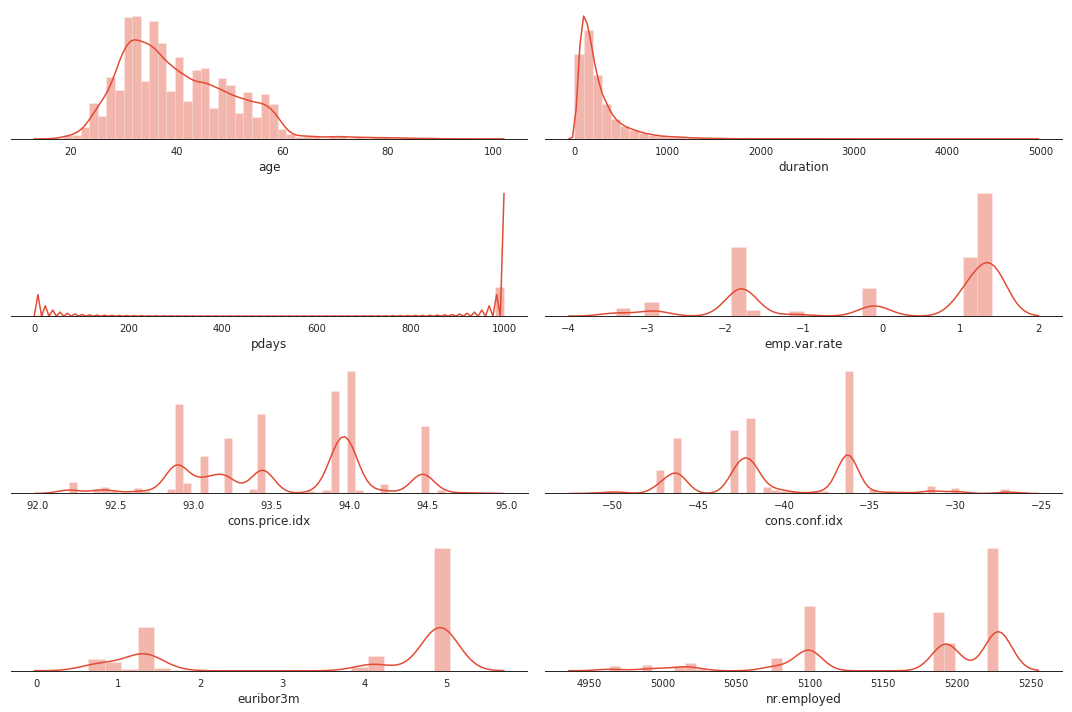

In [886]:
# Set up the matplotlib figure
f, axes = plt.subplots(4, 2, figsize=(15, 10))
sns.despine(left=True)

for i in range(4):
    for j in range(2):
        col = num_cols[ i * 2 + j]
        sns.distplot(subset_num_data[col], kde=True, ax=axes[i, j])
        plt.setp(axes, yticks=[])
        plt.tight_layout()

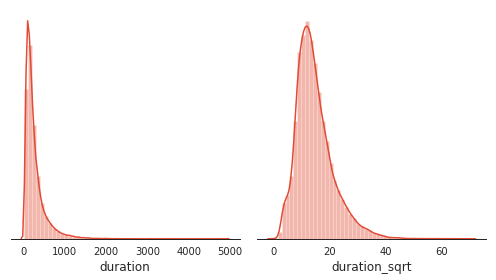

In [887]:
# Set up the matplotlib figure
f, axes = plt.subplots(1, 2, figsize=(7, 4))
sns.despine(left=True)

for dataset in datasets:
  dataset['duration_sqrt'] = np.sqrt(dataset['duration'])
  
sns.distplot(campaign_data['duration'], kde=True, ax=axes[0])
sns.distplot(campaign_data['duration_sqrt'], kde=True, ax=axes[1])

plt.setp(axes, yticks=[])
plt.tight_layout()

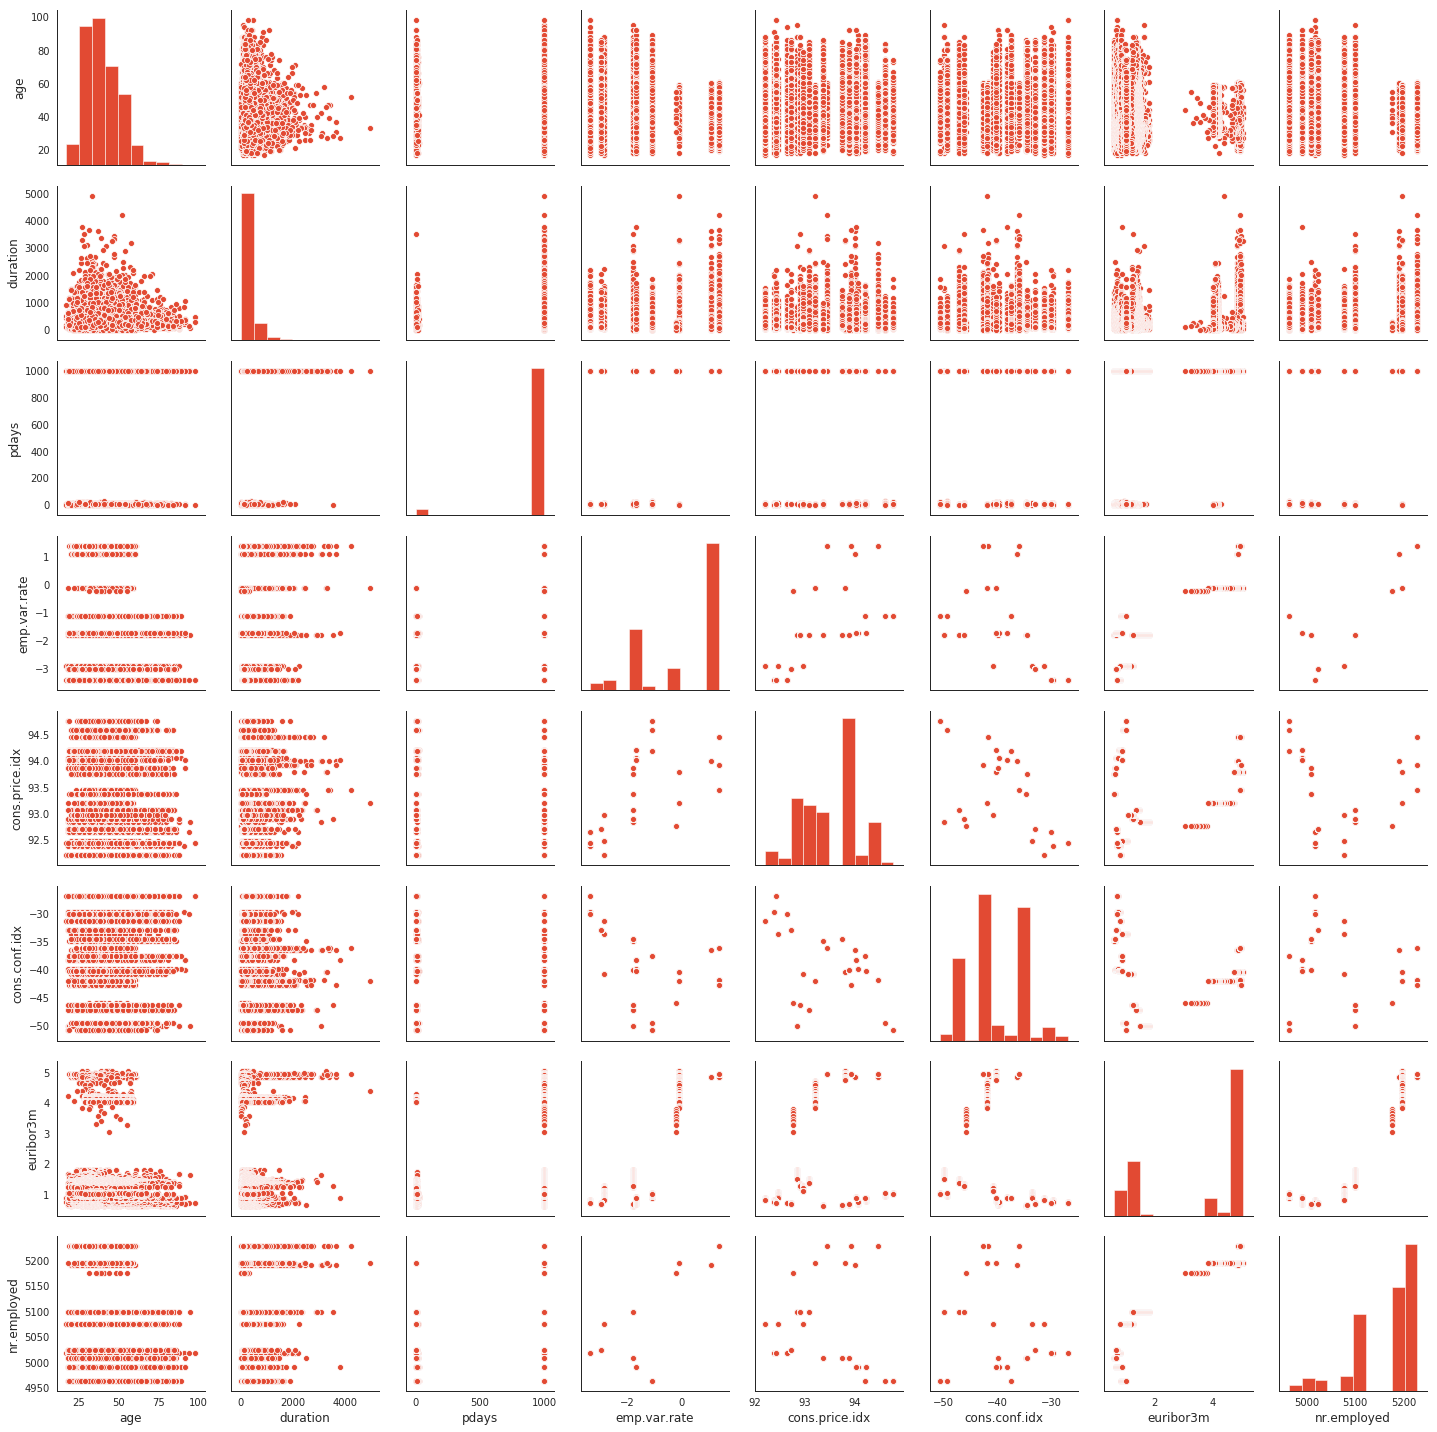

In [888]:
sns.pairplot(subset_num_data)

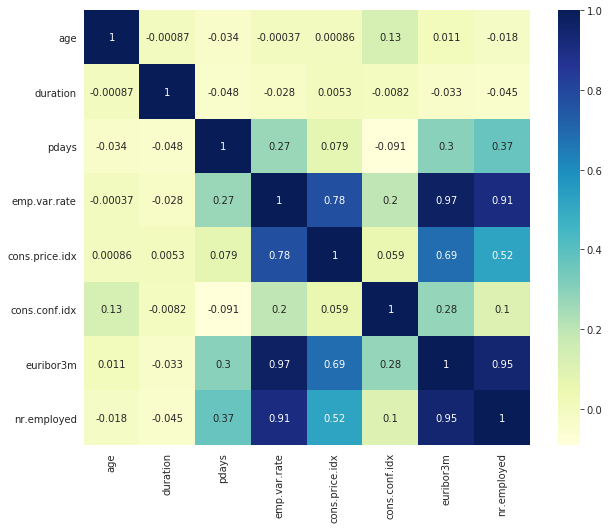

In [889]:
#Calculate the pearson co-efficient for all possible combinations
data_corr = subset_num_data.corr()
f, ax = plt.subplots(figsize = (10,8))
sns.heatmap(data_corr, annot=True, cmap="YlGnBu")

In [890]:
# Set the threshold and search for pairs which are having correlation level above threshold
corr_var_list = []
threshold = 0.5

for i in range(1, len(num_cols)):
    for j in range(i):
        if((abs(data_corr.iloc[i,j]) > threshold) & (abs(data_corr.iloc[i,j]) < 1)):
            corr_var_list.append([data_corr.iloc[i,j], i, j])

# Sort the list showing higher ones first 
s_corr_list = sorted(corr_var_list ,key = lambda x:abs(x[0]))

#Print correlations and column names
for corr_value, i, j in s_corr_list:
    print ("%s , %s = %.2f" % (num_cols[i],num_cols[j],corr_value))

nr.employed , cons.price.idx = 0.52
euribor3m , cons.price.idx = 0.69
cons.price.idx , emp.var.rate = 0.78
nr.employed , emp.var.rate = 0.91
nr.employed , euribor3m = 0.95
euribor3m , emp.var.rate = 0.97


In [0]:
campaign_data.drop(['euribor3m','emp.var.rate','cons.price.idx'], axis = 1, inplace = True)
campaign_data_validate.drop(['euribor3m','emp.var.rate','cons.price.idx'], axis = 1, inplace = True)

num_cols = [ 'age','duration','pdays','cons.conf.idx','nr.employed']

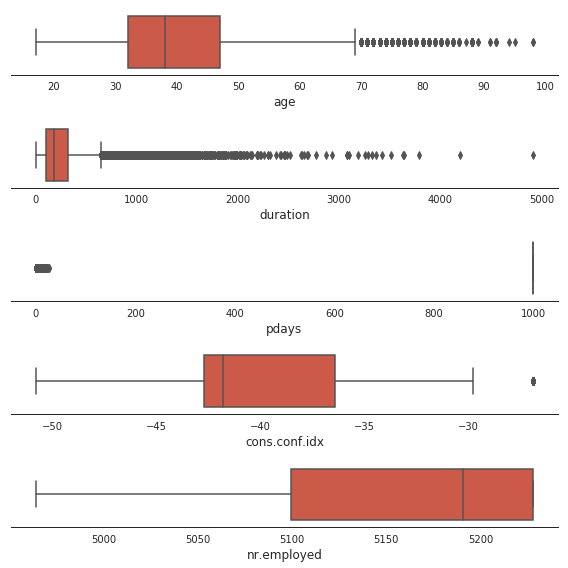

In [892]:
# Set up the matplotlib figure
f, axes = plt.subplots(len(num_cols), 1, figsize=(8, 8))
sns.despine(left=True)

for i in range(len(num_cols)):
        col = num_cols[i]
        sns.boxplot(x = subset_num_data[col], ax=axes[i])
        plt.setp(axes, yticks=[])
        plt.tight_layout()

**Categorical Data Visualization**

In [893]:
campaign_data.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'cons.conf.idx', 'nr.employed', 'y',
       'is_salaried', 'education_level', 'age_bin', 'avg_contact',
       'duration_sqrt'],
      dtype='object')

In [0]:
campaign_data.drop(['age','job','campaign','previous','duration','education'], axis = 1, inplace = True)
campaign_data_validate.drop(['age','job','campaign','previous','duration','education'], axis = 1, inplace = True)

In [0]:
num_cols = ['pdays','cons.conf.idx','nr.employed']

cat_cols = [ 'marital', 'default', 'housing', 'loan',
             'contact', 'month', 'day_of_week', 'pdays',
             'poutcome', 'is_salaried', 'education_level', 'age_bin',\
             'avg_contact', 'duration_sqrt']
target = ['y']

In [896]:
# create a subset of dataframe with only 'num_features'
subset_cat_data = campaign_data[cat_cols]
subset_cat_data.sample(3)

,marital,default,housing,loan,contact,month,day_of_week,pdays,poutcome,is_salaried,education_level,age_bin,avg_contact,duration_sqrt
28899,1,0,1,0,0,4,5,999,0,1,1,1,1.0,14.899664
24673,1,0,1,0,1,11,1,999,0,1,1,1,1.5,13.711309
25311,1,0,1,0,0,11,2,999,2,1,0,1,0.5,19.313208


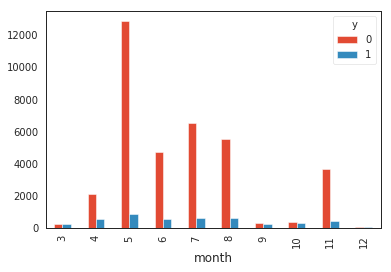

In [898]:
crosstab = pd.crosstab(index=campaign_data['month'], columns=campaign_data["y"])
crosstab.plot(kind='bar')
plt.show()

In [899]:
campaign_data.columns

Index(['marital', 'default', 'housing', 'loan', 'contact', 'month',
       'day_of_week', 'pdays', 'poutcome', 'cons.conf.idx', 'nr.employed', 'y',
       'is_salaried', 'education_level', 'age_bin', 'avg_contact',
       'duration_sqrt'],
      dtype='object')

**Visualize Data Imbalance**

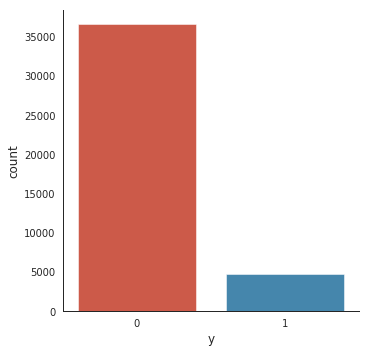

In [900]:
# To check Data Imbalance
sns.catplot('y',data=campaign_data,kind="count")

**Fit Different Models**

In [0]:
resample_model = [ClusterCentroids, TomekLinks, RandomOverSampler]
clf_method = ['LogisticRegression','Decision_Tree', 'RandomForest', 'RandomForest_BalancWeight', 'GridSearch_RandomForest']

In [0]:
X = campaign_data.drop(['y'], axis = 1)
y = campaign_data['y'].copy()
X_train, X_test,y_train, y_test = train_test_split(X, y, test_size = 0.3,random_state = 0)


col_0     0     1
y                
0      9342  1627
1       195  1193
Accuracy:0.8525532087076151
 Precision: 0.42304964539007095
 Recall: 0.8595100864553314
 f1_score:0.5670152091254753
 roc_auc_score:0.8555914913997871               
 classification_report:
               precision    recall  f1-score   support

           0       0.98      0.85      0.91     10969
           1       0.42      0.86      0.57      1388

   micro avg       0.85      0.85      0.85     12357
   macro avg       0.70      0.86      0.74     12357
weighted avg       0.92      0.85      0.87     12357



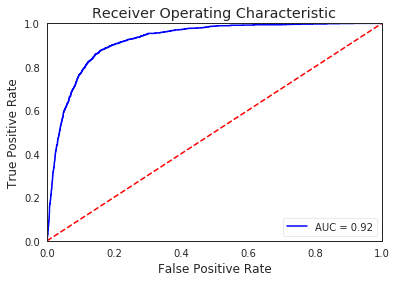

In [903]:
Resample_FitModel_Validate(resample_model = None , clf_method = 'LogisticRegression_BalanceWeight', plot = True,\
                               train_data = X_train, train_target = y_train, test_data = X_test, test_target = y_test)

col_0     0     1
y                
0      4214  6755
1        79  1309
Accuracy:0.44695314396698227
 Precision: 0.1623263888888889
 Recall: 0.9430835734870316
 f1_score:0.27697841726618705
 roc_auc_score:0.6636285767881872               
 classification_report:
               precision    recall  f1-score   support

           0       0.98      0.38      0.55     10969
           1       0.16      0.94      0.28      1388

   micro avg       0.45      0.45      0.45     12357
   macro avg       0.57      0.66      0.41     12357
weighted avg       0.89      0.45      0.52     12357



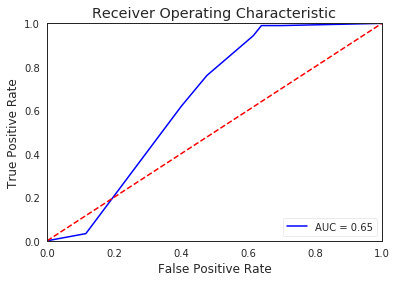

In [904]:
Resample_FitModel_Validate(resample_model = ClusterCentroids , clf_method = 'Decision_Tree', plot = True,\
                               train_data = X_train, train_target = y_train, test_data = X_test, test_target = y_test)

col_0      0    1
y                
0      10453  516
1        555  833
Accuracy:0.9133284777858703
 Precision: 0.6174944403261675
 Recall: 0.6001440922190202
 f1_score:0.6086956521739131
 roc_auc_score:0.7765512146754687               
 classification_report:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95     10969
           1       0.62      0.60      0.61      1388

   micro avg       0.91      0.91      0.91     12357
   macro avg       0.78      0.78      0.78     12357
weighted avg       0.91      0.91      0.91     12357



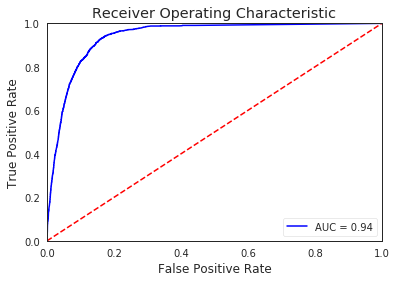

In [905]:
Resample_FitModel_Validate(resample_model = TomekLinks , clf_method = 'GridSearch_RandomForest', plot = True,\
                               train_data = X_train, train_target = y_train, test_data = X_test, test_target = y_test)

col_0     0     1
y                
0      9052  1917
1       121  1267
Accuracy:0.8350732378408999
 Precision: 0.39792713567839194
 Recall: 0.9128242074927954
 f1_score:0.5542432195975503
 roc_auc_score:0.8690294799885346               
 classification_report:
               precision    recall  f1-score   support

           0       0.99      0.83      0.90     10969
           1       0.40      0.91      0.55      1388

   micro avg       0.84      0.84      0.84     12357
   macro avg       0.69      0.87      0.73     12357
weighted avg       0.92      0.84      0.86     12357



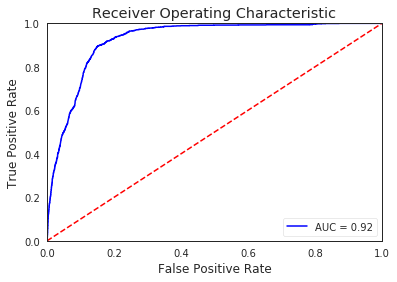

In [906]:
Resample_FitModel_Validate(resample_model = None , clf_method = 'RandomForest_BalancWeight', plot = True,\
                               train_data = X_train, train_target = y_train, test_data = X_test, test_target = y_test)

col_0     0     1
y                
0      9097  1872
1       125  1263
Accuracy:0.8383911952739338
 Precision: 0.4028708133971292
 Recall: 0.909942363112392
 f1_score:0.558478885695335
 roc_auc_score:0.8696397930978133               
 classification_report:
               precision    recall  f1-score   support

           0       0.99      0.83      0.90     10969
           1       0.40      0.91      0.56      1388

   micro avg       0.84      0.84      0.84     12357
   macro avg       0.69      0.87      0.73     12357
weighted avg       0.92      0.84      0.86     12357



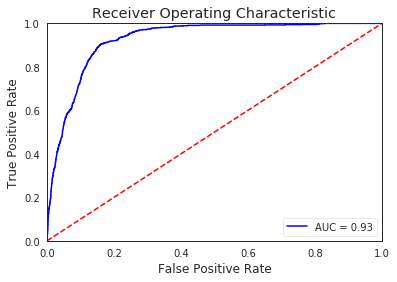

In [907]:
Resample_FitModel_Validate(resample_model = RandomOverSampler , clf_method = 'RandomForest', plot = True,\
                               train_data = X_train, train_target = y_train, test_data = X_test, test_target = y_test)

**Validation on "campaign_data_validate"**

In [0]:
X_validate = campaign_data_validate.drop(['y'], axis = 1)
y_validate = campaign_data_validate['y'].copy()


col_0     0    1
y               
0      3561  107
1       108  343
Accuracy:0.9478028647730031
 Precision: 0.7622222222222222
 Recall: 0.7605321507760532
 f1_score:0.7613762486126526
 roc_auc_score:0.8656804701535664               
 classification_report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97      3668
           1       0.76      0.76      0.76       451

   micro avg       0.95      0.95      0.95      4119
   macro avg       0.87      0.87      0.87      4119
weighted avg       0.95      0.95      0.95      4119



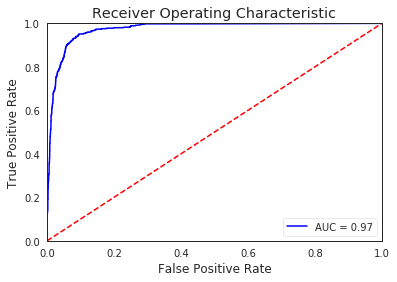

In [909]:

Resample_FitModel_Validate(resample_model = TomekLinks , clf_method = 'GridSearch_RandomForest', plot = True,\
                               train_data = X_train, train_target = y_train, test_data = X_validate, test_target = y_validate)